# Predicting Diabetes with Logistic Regression & NN with PyTorch

Here, we use the diabetes dataset to illustrate logistic regression and neural network models

You may also run it on Google Colab with this link: [demo_pytorch_LR.ipynb](https://colab.research.google.com/github/huangyh09/nnwrapper/blob/main/examples/demo_pytorch_LR.ipynb)

## Import Libraries and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 
             'bmi', 'pedigree', 'age', 'diabetes']

# load dataset
github_path = 'https://raw.githubusercontent.com/huangyh09/foundation-data-science/'
dat_dir = github_path + 'main/w10-classification/'

# dat_dir = './'

pima = pd.read_csv(dat_dir + "diabetes.csv", skiprows=1, names=col_names)

In [3]:
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
pima.shape, np.mean(pima.diabetes)

((768, 9), 0.3489583333333333)

## Selecting Feature and splitting data

For Features considering all the columns except label, as it is our Target.

In [5]:
feature_cols = ['pregnant', 'glucose', 'bp','skin', 
                'insulin', 'bmi', 'pedigree','age']

X = pima[feature_cols] # Features
y = pima.diabetes      # Target variable

In [6]:
X1 = pima[feature_cols].values.astype(np.float32)

Y1 = pima.diabetes.values.astype(np.float32).reshape(-1, 1)
Y1 = np.concatenate([1 - Y1, Y1], axis=1) 

##### Standardisation makes it easier for the optimizer

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X1, Y1, test_size=0.25, random_state=0
)

In [9]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(576, 8)

(576, 2)

(192, 8)

(192, 2)

### Scikit-learn logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train[:, 1])

P_hat_prob = clf.predict_proba(X_test)[:, 1]
y_pred = (P_hat_prob >= 0.5).astype(int)

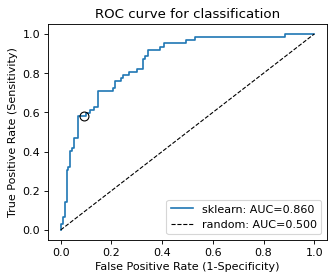

In [11]:
from hilearn import ROC_plot
fig = plt.figure(figsize=(4.5, 3.5), dpi=80)
ROC_plot(y_test[:, 1], P_hat_prob, legend_label="sklearn", threshold=0.5, base_line=True)
plt.title("ROC curve for classification")

# fig.savefig("cv_classification.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Neural Network model with PyTorch

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_data = TensorDataset(Tensor(X_train), Tensor(y_train))
test_data  = TensorDataset(Tensor(X_test), Tensor(y_test))

/mnt/yuanhua/nfs_share/anaconda3/envs/PyTch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
train_loader = DataLoader(train_data, batch_size=756, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_data,  batch_size=192, shuffle=False)

In [14]:
X_train.shape, len(train_loader.dataset)

((576, 8), 576)

In [15]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

#### Model
Set up model with the torch.nn module and train it with nnwrapper

In [16]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(8, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [17]:
from nnwrapper import NNWrapper

model = Net1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)

my_wrapper = NNWrapper(model, criterion, optimizer)
my_wrapper.fit(train_loader, epoch=1000, validation_loader=None, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.05it/s]


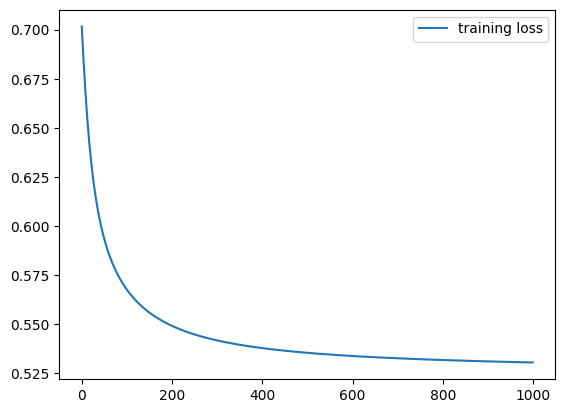

In [18]:
plt.plot(my_wrapper.train_losses, label='training loss')
# plt.plot(my_wrapper.valid_losses, label='test loss')
plt.legend()

In [19]:
y_obs  = torch.cat([y for x, y in test_loader])

y_pred, val_loss = my_wrapper.predict(test_loader)

acc, auc, confu  = my_wrapper.evaluate(y_pred, y_obs)
acc, auc

(0.8020833333333334, 0.8558312655086848)

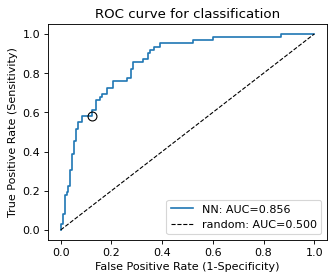

In [20]:
from hilearn import ROC_plot

_y_scores = y_pred[:, 1].cpu().data.numpy() 
_y_obs    = y_obs[:, 1].cpu().data.numpy()

fig = plt.figure(figsize=(4.5, 3.5), dpi=80)
ROC_plot(_y_obs, _y_scores, legend_label="NN", threshold=0.5, base_line=True)
plt.title("ROC curve for classification")

# fig.savefig("cv_classification.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Try two-layer neural net?

In [21]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x